## BUPA liver data
1. mcv:	mean corpuscular volume
2. alkphos:	alkaline phosphotase
3. sgpt:	alamine aminotransferase
4. sgot: 	aspartate aminotransferase
5. gammagt:	gamma-glutamyl transpeptidase
6. drinks:	number of half-pint equivalents of alcoholic beverages drunk per day
7. selector  field used to split data into two sets

In [2]:
import numpy as np
import pandas as pd
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/liver-disorders/bupa.data'
urllib.request.urlretrieve(url, './bupa.data')

('./bupa.data', <http.client.HTTPMessage at 0x7ff9ea3557f0>)

In [4]:
bupa_dataset = pd.read_csv('./bupa.data',sep=',',header=-1)  
bupa_dataset.columns = ['mcv', 'alkphos','sgpt','sgot','gammagt','drinks','selector']

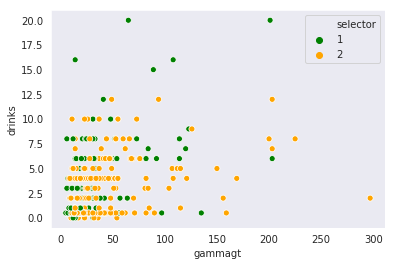

In [6]:
sns.set_style("dark")
fig, ax = plt.subplots()
ax.margins(0.05) 
ax = plt.gca()
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
# fig_dims = (7, 7)

sns.scatterplot(x="gammagt", y="drinks", hue="selector",marker='o',data=bupa_dataset, ax=ax, palette=['green','orange'])
plt.xlabel(bupa_dataset.columns[4])
plt.ylabel(bupa_dataset.columns[5])
plt.show()
# # plotar o KDE sem normalização

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(bupa_dataset[['mcv', 'alkphos','sgpt','sgot','gammagt','drinks']])
# print(scaler.mean_)
bupa_dataset_scaled = scaler.transform(bupa_dataset[['mcv', 'alkphos','sgpt','sgot','gammagt','drinks']])
bupa_dataset_scaled = np.append(bupa_dataset_scaled, bupa_dataset['selector'].values.reshape(-1,1), axis=1)
bupa_dataset_norm = pd.DataFrame(data=bupa_dataset_scaled, columns=bupa_dataset.columns)

/home/makquel/anaconda3/envs/zika_maria/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/makquel/anaconda3/envs/zika_maria/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


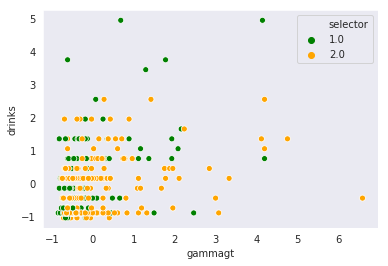

In [7]:
sns.set_style("dark")
fig, ax = plt.subplots()
ax.margins(0.05) 
ax = plt.gca()
sns.scatterplot(x="gammagt", y="drinks", hue="selector",marker='o',data=bupa_dataset_norm, ax=ax, palette=['green','orange'])
plt.xlabel(bupa_dataset_norm.columns[4])
plt.ylabel(bupa_dataset_norm.columns[5])
plt.show()

In [8]:
print(bupa_dataset_norm[bupa_dataset_norm['selector']==1.].shape)
print(bupa_dataset_norm[bupa_dataset_norm['selector']==2.].shape)

(145, 7)
(200, 7)


In [9]:
from sklearn.model_selection import train_test_split
X = bupa_dataset_norm[['mcv', 'alkphos','sgpt','sgot','gammagt','drinks']]
y = bupa_dataset_norm['selector'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
# print(X.shape)
# np.asarray(X_train)[0,:].shape
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
# X_train[np.where(y_train==1)[0],:]
# prob.shape

In [ ]:
# X_test = np.array([[0.5,0.5],[0.8,0.2],[0.4,0.7]])
# prob = np.zeros((X_test.shape[0],max(y)[0])) 
# X_train[0,:] 

In [16]:
def PNN_fit(X_train,X_test,y_train,y_test,sigma):
    # n_classes = len(my_data.groupby('<class_name_space>''))
    ## TODO: improve the number of classes value
    n_classes = max(y_train)
    prob = np.zeros((X_test.shape[0],max(y_train))) 
    # X_test = np.array([[0.5,0.5],[0.8,0.2],[0.4,0.7]])
    # prob = np.zeros((X_test.shape[0],max(y)[0]))

    ## loop through all the X_test data (unclassified points)
    for point in range(0,X_test.shape[0]):
        x_test = X_test[point,:] 
    #     print(x_test)
        ## loop through i-th class
        for i in range(1,n_classes+1):
            X_i = X_train[np.where(y_train == i)[0],:]
            summ = 0.
            ## loop through j-th element of the i-th class
            for j in range(0,X_i.shape[0]):
                ## norm L2 (sum of squares)
                norm = 0.
                ## loop through k-th feature
                for k in range(0,X_i.shape[1]):
                    ## TODO: covariance form X*M*X'
                    norm = norm + (X_i[j,k]-x_test[k])*(X_i[j,k]-x_test[k])  
                ## Summation of Gaussians
                summ = summ + np.exp((-1/2)*(1/(2*sigma**2))*norm)
            ## Average of Parzen Window (normalization term)
            summ = summ/X_i.shape[0]
            ## Decision boundary
            prob[point, (i-1)] = summ
    
    return prob

def PNN_score(prob):
    # argmax of each 
    y_prob = np.asarray([max(prob[i,:]) for i in range(0,prob.shape[0])])
    y_bar = np.asarray([np.where(prob[ix,:] == max(prob[ix,:]))[0][0]+1 for ix in range(0,prob.shape[0])])
    
    return y_bar

In [17]:
prob = PNN_fit(X_train,X_test,y_train,y_test,sigma = 0.1)
y_bar =  PNN_score(prob)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_bar)

0.625